# Curve di possibilità pluviometrica - Monte Bondone (TN)

### Università degli Studi di Trento - Corso di Idrologia
### Autori:

- Giulia Omilli   209480
- Aya Essamih   209743
- Maria Eugenia Boccardi     209189


*Copyright: Creative Commons 4.0*

## Sommario

In questo Notebook calcoliamo le curve di possibilità pluvimetrica del Monte Bondone (TN) utilizzando i dati forniti dal servizio meteorologico della città. I dati sono disponibili all'indirizzo http://www.meteotrentino.it. 
La Stazione Monte Bondone contiene una serie di dati relativi all’arco temporale  1926-2002. 

In questo notebook in particolare si analizzano i massimi annuali **suborari: 15min, 30min, 45min**. 
Per la determinazione dei tempi di ritorno si usa la curva di distribuzione di Gumbel:

$$ P[H<h; a,b] = e^{-e-{\frac{h-a}{b}}}$$

i cui parametri sono stati determinati usando i metodi dei momenti, dei minimi quadrati e della massima verosimiglianza. 

Il test di Pearson è stato usato per discriminare la migliore seie di parametri per ogni durata. 


## Caricamento delle librerie

Qui sono caricate le librerie necessarie ai calcoli

In [1]:
import os 
import math
from pandas import *
import pandas as pd
import datetime as datetime 
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme,gumbel_r
from scipy.stats import norm
from numpy import linspace
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.optimize import least_squares
from pylab import plot,show,hist,figure,title
import matplotlib.image as mpimg
import folium
from IPython.display import Image

In [2]:
os.getcwd()
os.chdir("/Users/user/Desktop/ES 1")

## Descrizione del sito e della stazione di misura

Sono caricate una tabella che contiene le informazioni rilevanti, una foto e una mappa che localizza la stazione di misura

In [3]:
stazione = pd.read_csv('Stazione Monte.csv')
stazione=stazione.set_index('Stazione meteorologica')
stazione

,Dettagli
Stazione meteorologica,
,T0144
Località,Monte Bondone
Coordinata Est,659010
Coordinata Nord,5097598
Longitudine,11°03’14.6” E
Latitudine,46°00’48.6” N
Comune,Trento
Provincia,Trento
Regione,Trentino-Alto Adige


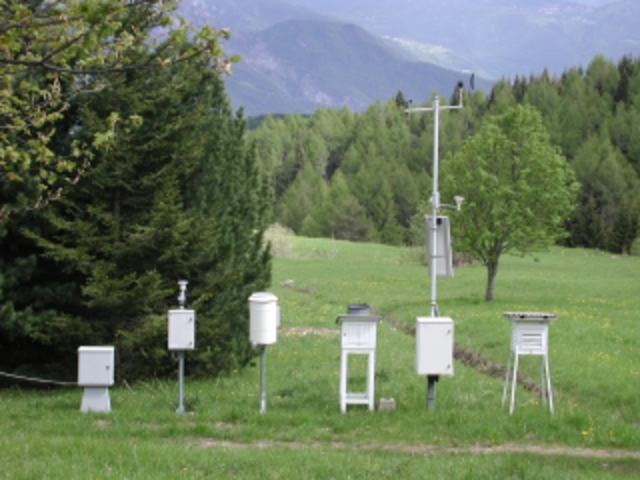

In [4]:
Image("Foto.jpg")

In [5]:
data = pd.DataFrame({
'lat':[46.0135],
'lon':[11.054056],
'name':['Stazione_meteorologica_Monte_Bondone']
})


m=folium.Map(width='100%',height='100%',location=[46.0135,11.054056], zoom_start=16)

for i in range(0,len(data)):
    folium.Marker([data.iloc[i]['lat'], data.iloc[i]['lon']], popup=data.iloc[i]['name']).add_to(m)

m.save('Stazione_meteorologica_Monte_Bondone_map.html')
m

## Caricamento dei Dati

Sono caricati e visualizzati i dati della stazione

In [6]:
dati = pd.read_csv('monte bondone suborarie.txt')
map(datetime,dati['anno'])
dati=dati.set_index('anno')

In [7]:
dati

,15min,30min,45min
anno,,,
1956,NaN,NaN,16.2
1957,10.0,16.0,NaN
1959,8.0,NaN,NaN
1960,14.5,NaN,NaN
1967,8.0,9.0,NaN
1968,17.4,NaN,NaN
1972,10.2,12.8,15.4
1973,10.4,12.4,13.0
1976,NaN,14.0,NaN


## Visualizzazione dei dati

Text(0.5, 0, 'anno')

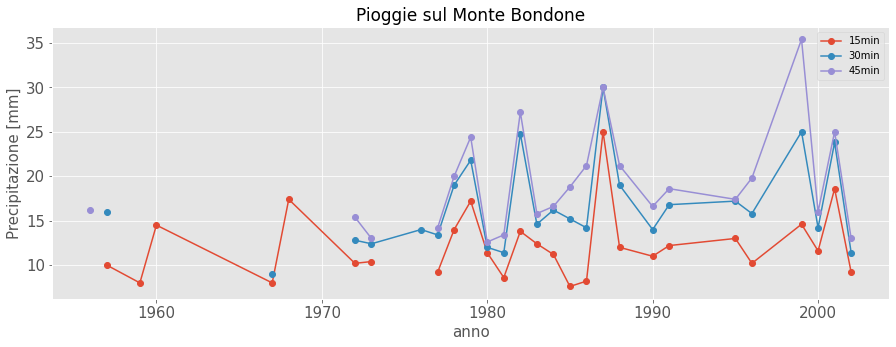

In [8]:
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.style.use("ggplot")
ax=dati.plot(style="o-",figsize=(15,5))
ax.set_title('Pioggie sul Monte Bondone',fontsize=17)
ax.set_ylabel("Precipitazione [mm]",fontsize=15)
ax.set_xlabel("anno", fontsize=15)

### Calcolo della media delle precipitazioni

In [9]:
media=dati.mean()

Text(0, 0.5, 'altezza di precipitazione (mm)')

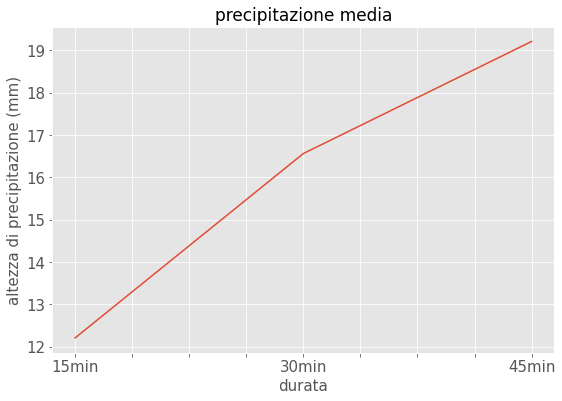

In [10]:
m=media.plot(color="#E24A33",figsize=(9,6))
m.grid(True)
m.set_title('precipitazione media',fontsize=17)
m.set_xlabel('durata',fontsize=15)
m.set_ylabel('altezza di precipitazione (mm)',fontsize=15)

### Calcolo della varianza

In [11]:
varianza=dati.var()

Text(0.5, 0, 'durata')

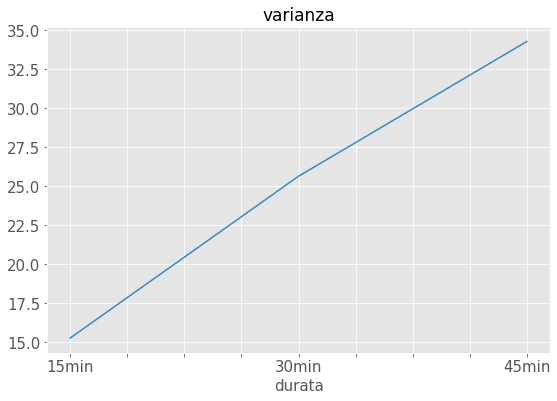

In [12]:
v=varianza.plot(color="#348ABD",figsize=(9,6))
v.grid(True)
v.set_title('varianza',fontsize=17)
v.set_xlabel('durata',fontsize=15)

### Calcolo della deviazione standard

In [13]:
std=dati.std()
devstd=std/media

Text(0.5, 0, 'durata')

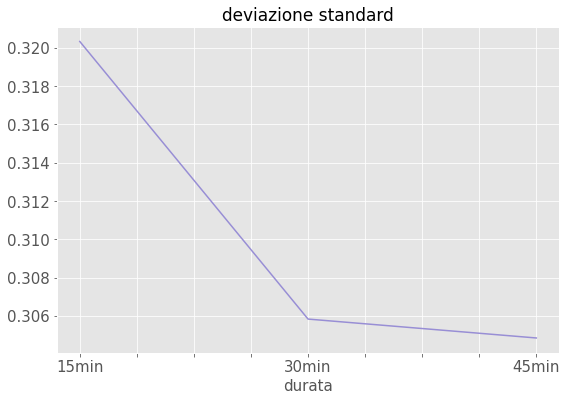

In [14]:
ds=devstd.plot(color="#988ED5",figsize=(9,6))
ds.grid(True)
ds.set_title('deviazione standard',fontsize=17)
ds.set_xlabel('durata',fontsize=15)

## Interpolazione delle curve di Gumbel

## Metodo dei momenti

Il metodo dei momenti consiste nel eguagliare media e varianza del campione con media e varianza della popolazione


\begin{equation}
\left\{
\begin{array}{l}
b \gamma + a = \mu_H \\
\sigma^2_H = b^2  \frac{\pi^2}{6}
\end{array}
\right.
\end{equation}
con $a$ e $b$ parametri da stimare, $\mu_H$ media dei campioni di dati e $\sigma_H$ deviazione standard 

Si ricava:
\begin{equation}
b = \frac{\sqrt{6}}{\pi} \sigma_H
\end{equation}

\begin{equation}
a = \mu_H -\frac{\sqrt{6}\gamma}{\pi} \sigma_H 
\end{equation}

In [15]:
gamma=0.577215664901532860606512090
j=math.sqrt(6)/math.pi
b=gamma*j

In [16]:
def f(m,s):
    return pd.DataFrame([m-b*s,j*s],index=["a","b"])

In [17]:
ab_momenti=f(media,std)
ab_momenti

,15min,30min,45min
a,10.444352,14.280668,16.573327
b,3.047997,3.948839,4.565657


In [18]:
ab_momenti.to_pickle("ab_momenti")

In [19]:
def gumbel(x,ab,col):
    return np.exp(-np.exp(-(x-ab[col]["a"])/ab[col]["b"]))

In [20]:
dati.min()[0]

7.6

In [21]:
dati.max()[2]

35.4

In [22]:
tpioggia=np.linspace(dati.min()[0]-3,dati.max()[2]+3,100)

In [23]:
def metodo(data,train,ab_i):
    c=[]
    for i in data.columns:
        c.append(gumbel(train,ab_i,i))
    g_i=pd.DataFrame(c).T
    g_i.index=train
    g_i.columns=["15min","30min","45min"]
    return g_i

g_mm=metodo(dati,tpioggia,ab_momenti)
g_mm

,15min,30min,45min
4.600000,0.001110,0.000009,0.000001
4.941414,0.002282,0.000024,0.000003
5.282828,0.004348,0.000058,0.000007
5.624242,0.007737,0.000129,0.000017
5.965657,0.012951,0.000271,0.000037
...,...,...,...
37.034343,0.999837,0.996860,0.988747
37.375758,0.999855,0.997120,0.989554
37.717172,0.999870,0.997358,0.990303
38.058586,0.999884,0.997577,0.990998


<AxesSubplot:xlabel='pioggia (mm)', ylabel='P[H<h]'>

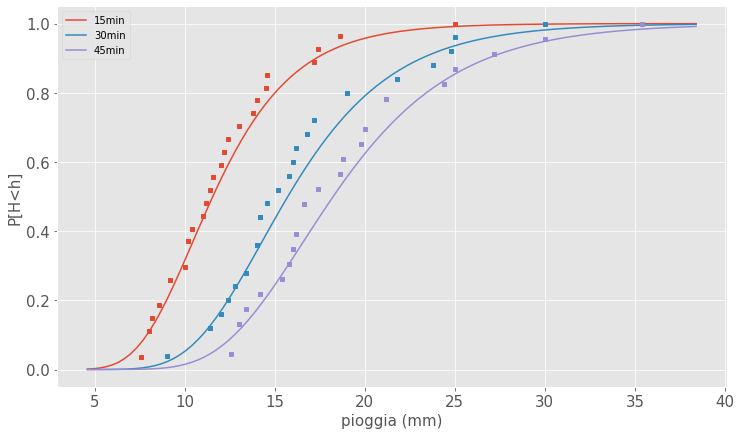

In [24]:
def grafico(data,gb,colours):
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15) 
    plt.style.use("ggplot")
    plt.rcParams["figure.figsize"]=(12,7)
    ax=gb.plot(color=colours)
    i=0
    for j in data.columns:
        d=data[j].dropna()
        ecdf_i=ECDF(d)
        ax.plot(d,ecdf_i(d),'s',c=colours[i],markersize=3.5)
        i+=1
    ax.set_xlabel('pioggia (mm)', fontsize=15)
    ax.set_ylabel('P[H<h]', fontsize=15)
    ax.grid(True)
    #ax.set_aspect(80)
    return ax

#colori=["blue","green","orange","red","black"]
#colori=["#E24A33","#348ABD","#988ED5","#777777","#FBC15E"]
colori=["#E24A33","#348ABD","#988ED5"]
#colori = plt.rcParams['axes.prop_cycle'].by_key()['color']
grafico(dati,g_mm,colori)

## Metodo della massima verosimiglianza

Il metodo della massima verosimiglianza calcola i valori dei parametri per cui  la probabilità congiunta di ottenere una serie di dati $\{h_1, \cdot \cdot, h_n \}$ è massima:
\begin{equation}
{\rm argmax}_{a,b} P[\{h_1, \cdot \cdot, h_n \};a,b] = {\rm argmax}_{a,b} \prod_i^n P[h_i;a,b]
\end{equation}

In [25]:
def veroS(data):
    p=[]
    for j in data.columns:
        samp=data[j].dropna()
        param=gumbel_r.fit(samp)
        p.append(param)
    return p

ab_maxver=pd.DataFrame(veroS(dati),
                     columns=["a","b"],
                     index=["15min","30min","45min"]).T
ab_maxver

,15min,30min,45min
a,10.559199,14.350711,16.704823
b,2.659784,3.664758,4.004812


In [26]:
ab_maxver.to_pickle("ab_maxver")

In [27]:
g_mv=metodo(dati,tpioggia,ab_maxver)
g_mv

,15min,30min,45min
4.600000,0.000083,6.124098e-07,1.196312e-09
4.941414,0.000257,2.186286e-06,6.411316e-09
5.282828,0.000696,6.969640e-06,2.995497e-08
5.624242,0.001671,2.004127e-05,1.233896e-07
5.965657,0.003610,5.246091e-05,4.527380e-07
...,...,...,...
37.034343,0.999952,9.979516e-01,9.937763e-01
37.375758,0.999958,9.981336e-01,9.942834e-01
37.717172,0.999963,9.982995e-01,9.947494e-01
38.058586,0.999968,9.984507e-01,9.951774e-01


<AxesSubplot:xlabel='pioggia (mm)', ylabel='P[H<h]'>

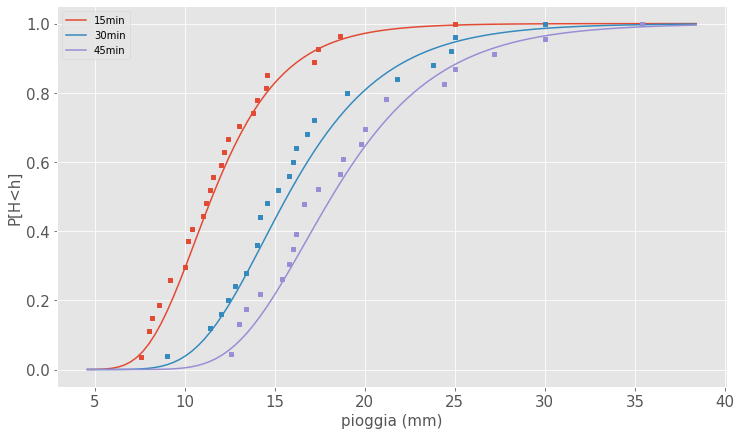

In [28]:
grafico(dati,g_mv,colori)

## Metodo dei minimi quadrati

Il metodo dei minimi quadrati consiste nel minimizzare lo scarto quadratico tra il valore empirico e quello della probabilità:
\begin{equation} 
\delta^2(a,b) = \sum_i^N (ECDF_i-P[h_i;a,b])^2 \to \rm min 
\end{equation}

In [29]:
def fun(x,t,y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y

In [30]:
def quadrato(data,x_i):
    z=[]
    j=0
    for i in data.columns:
        ecdf_i=ECDF(data[i].dropna())
        t_tpioggia=sorted(data[i].dropna())
        y_tpioggia=ecdf_i(t_tpioggia)
        res_lsq_i = least_squares(fun, x_i[j], args=(t_tpioggia, y_tpioggia))
        z.append(res_lsq_i.x)
        j=j+1
    return z

In [31]:
x=[[10.,3.],[14.,4.],[17.,4.]]
ab_mq=pd.DataFrame(quadrato(dati,x),columns=["a","b"],
                     index=["15min","30min","45min"]).T
ab_mq

,15min,30min,45min
a,10.189686,13.852024,16.001263
b,2.757853,3.361944,4.075533


In [32]:
ab_mq.to_pickle("ab_mq")

In [33]:
g_mq=metodo(dati,tpioggia,ab_mq)
g_mq

,15min,30min,45min
4.600000,0.000506,1.559489e-07,7.517656e-08
4.941414,0.001223,7.084531e-07,2.809000e-07
5.282828,0.002671,2.780763e-06,9.441002e-07
5.624242,0.005325,9.564688e-06,2.878580e-06
5.965657,0.009796,2.919907e-05,8.024757e-06
...,...,...,...
37.034343,0.999941,9.989882e-01,9.942794e-01
37.375758,0.999948,9.990859e-01,9.947379e-01
37.717172,0.999954,9.991741e-01,9.951597e-01
38.058586,0.999959,9.992538e-01,9.955478e-01


<AxesSubplot:xlabel='pioggia (mm)', ylabel='P[H<h]'>

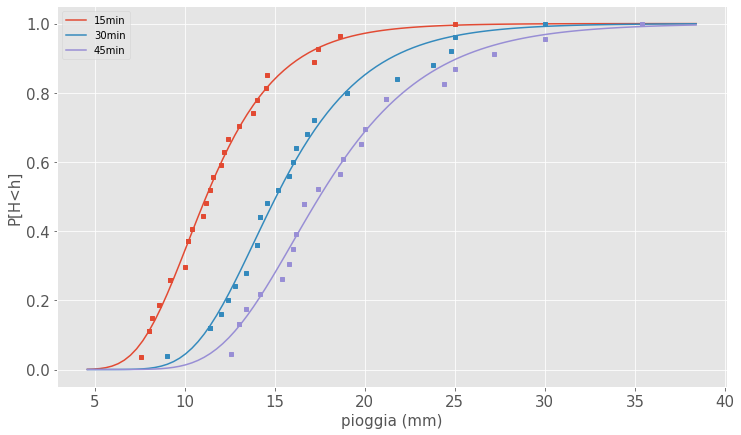

In [34]:
grafico(dati,g_mq,colori)

## Test di Pearson

La formula dell'$X^2$ è:
\begin{equation}
X^2 = \frac{1}{e}\sum_{i=1}^k (e - o)^2
\end{equation}

In [35]:
ab_momenti=pd.read_pickle("ab_momenti")
ab_maxver=pd.read_pickle("ab_maxver")
ab_mq=pd.read_pickle("ab_mq")

In [36]:
def X2(dati,ab_t,h,delta):    
    dt=dati[h].dropna()
    lh=len(dt)
    q=[delta*(i+1) for i in range(int(1/delta))]
    rv=gumbel_r(loc=ab_t.at["a",h],scale=ab_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    o0=lh*r
    o=o0-np.append([0],np.delete(o0,-1))
    e=[delta*lh for i in range(len(r))]
    return ((o-e)**2/e).sum()  

In [37]:
for  h in dati.columns:
    print(h,": ",[X2(dati,ab_momenti,h,0.2),X2(dati,ab_mq,h,0.2),X2(dati,ab_maxver,h,0.2)])

15min :  [0.9629629629629652, 0.22222222222222054, 0.9629629629629651]
30min :  [1.6, 1.9999999999999964, 1.6]
45min :  [1.1304347826086962, 0.260869565217392, 1.1304347826086962]


In [38]:
a=[]
for  h in dati.columns:
    a=a+[[X2(dati,ab_momenti,h,0.2),X2(dati,ab_mq,h,0.2),X2(dati,ab_maxver,h,0.2)]]
   
pd.DataFrame(a,index=["15min","30min","45min"],columns=["mm","mq","maxver"])

,mm,mq,maxver
15min,0.962963,0.222222,0.962963
30min,1.600000,2.000000,1.600000
45min,1.130435,0.260870,1.130435


In [39]:
z=[]
k=0
for i in a:
    minimo=min(i)
    pos=i.index(minimo)
    if pos==0:
        z.append(ab_momenti[dati.columns[k]])
    elif pos==1:
        z.append(ab_mq[dati.columns[k]])
    else:
        z.append(ab_maxver[dati.columns[k]])
    k+=1
best=DataFrame(z).T                
best

,15min,30min,45min
a,10.189686,14.280668,16.001263
b,2.757853,3.948839,4.075533


In [40]:
best.to_pickle("best_param")

In [41]:
g_best=metodo(dati,tpioggia,best)
g_best

,15min,30min,45min
4.600000,0.000506,0.000009,7.517656e-08
4.941414,0.001223,0.000024,2.809000e-07
5.282828,0.002671,0.000058,9.441002e-07
5.624242,0.005325,0.000129,2.878580e-06
5.965657,0.009796,0.000271,8.024757e-06
...,...,...,...
37.034343,0.999941,0.996860,9.942794e-01
37.375758,0.999948,0.997120,9.947379e-01
37.717172,0.999954,0.997358,9.951597e-01
38.058586,0.999959,0.997577,9.955478e-01


<AxesSubplot:xlabel='pioggia (mm)', ylabel='P[H<h]'>

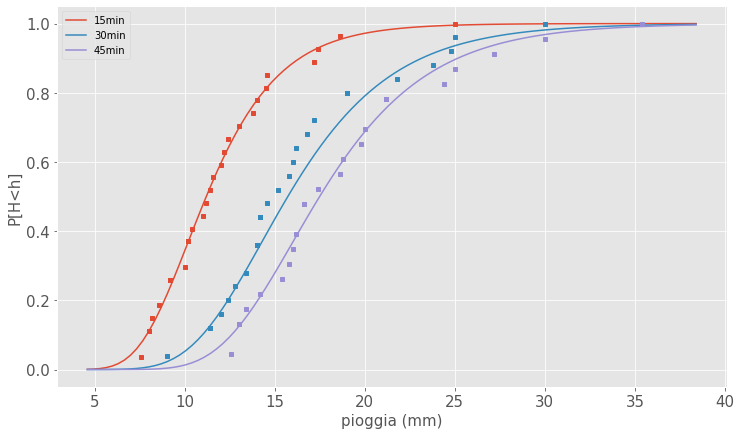

In [42]:
grafico(dati,g_best,colori)

## Visualizzazione delle curve di possibilità pluviometrica

Le curve di possibilità pluviometrica hanno la seguente equazione:

\begin{array}{l}
h(t_p,Tr)=a(Tr)t_p^n
\end{array}

$h(t_p,Tr)$ = altezza di precipitazione [mm]

$t_p$= durata dell'evento [ore]

$a(Tr)$=coefficiente dipendente dal tempo di ritorno [mm /ore]

$n$ =esponente adimensionale, che non dipende dal tempo di ritorno


Tramite la linea segnalatrice di possibilità pluviometrica per una determinata durata della pioggia $tp$, è possibile calcolare il massimo valore di $h$ per un prefissato tempo di ritorno $Tr$.

In [43]:
best=pd.read_pickle("best_param")
best

,15min,30min,45min
a,10.189686,14.280668,16.001263
b,2.757853,3.948839,4.075533


In [44]:
def qtls(df,qu):
    rv1h=gumbel_r(loc=df["a"],scale=df["b"])
    return rv1h.ppf(qu)

In [45]:
def h_g(bs,col,tr):
    return bs[col]["a"]+bs[col]["b"]*(-math.log(-math.log(1-1/tr)))

In [46]:
tr=[10,20,100]
t=[]
for k in tr:
    q_k=1-1/k
    r=[]
    for j in dati.columns:
        r.append(qtls(best[j],q_k))
    t.append(r)
pts=DataFrame(t,index=tr,columns=[15,30,45]).T
pts

,10,20,100
15,16.395868,18.381047,22.876221
30,23.167007,26.009491,32.445917
45,25.172709,28.106392,34.749323


(5.0, 40.0)

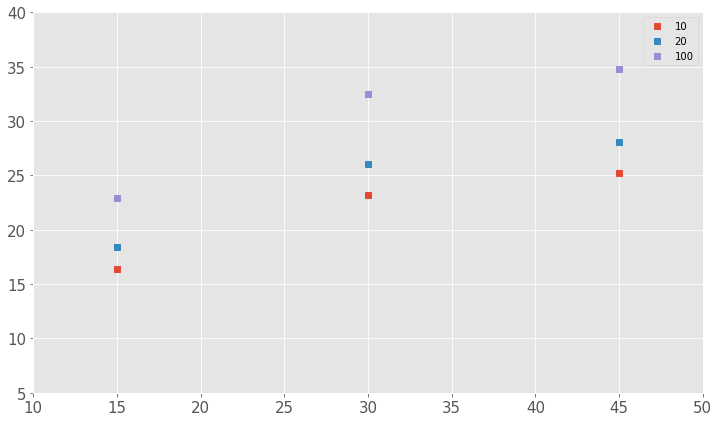

In [47]:
pts.plot(style="s")
plt.xlim([10,50])
plt.ylim([5,40])

(10, 50)

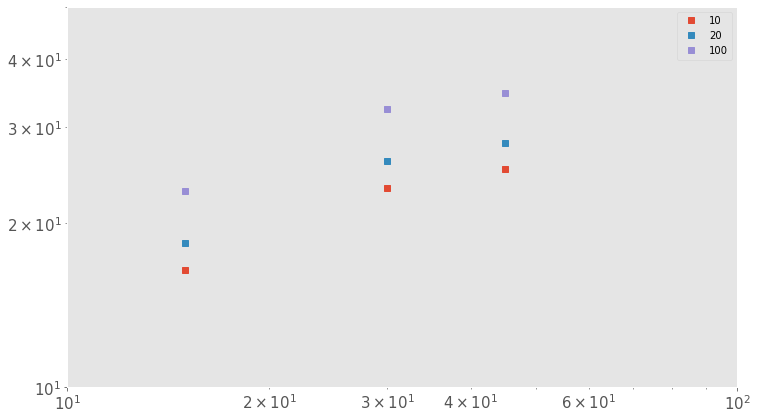

In [48]:
ag=pts.plot(style="s")
ag.set_yscale('log')
ag.set_xscale('log')
plt.xlim([10,100])
plt.ylim([10,50])

In [49]:
f=[1,2,3,4]
g=[1,2,3,4]
np.polyfit(f,g,1)

array([1.00000000e+00, 8.25508711e-16])

In [50]:
y=[]
for k in tr:
    in_i=np.polyfit(np.log(pts[k].index),np.log(pts[k]),1)
    in_i[1]=np.exp(in_i[1])
    y.append(in_i)

In [51]:
fnl=pd.DataFrame(y,index=tr,columns=["n","a"])
fnl

,n,a
10,0.401930,5.621907
20,0.398862,6.361312
100,0.393852,8.037718


In [52]:
tp=np.linspace(0.7,50,100)

In [53]:
def h(tp,a,n):
    return a*tp**n

In [54]:
e=[]
for k in tr:
    h_i=h(tp,fnl["a"][k],fnl["n"][k])
    e.append(h_i)

In [55]:
inh=pd.DataFrame(e,index=["Tr = 10","Tr = 20","Tr = 100"],
              columns=tp).T
inh

,Tr = 10,Tr = 20,Tr = 100
0.700000,4.871064,5.517753,6.984324
1.197980,6.045259,6.836553,8.630386
1.695960,6.951727,7.853291,9.896655
2.193939,7.709606,8.702580,10.952787
2.691919,8.370255,9.442388,11.871713
...,...,...,...
48.008081,26.647415,29.796020,36.925051
48.506061,26.758169,29.918913,37.075432
49.004040,26.868246,30.041050,37.224879
49.502020,26.977655,30.162444,37.373409


(0.0, 40.0)

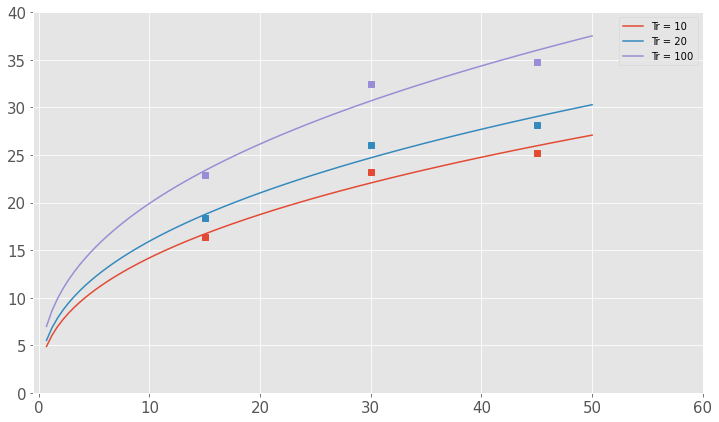

In [56]:
ag=inh.plot()
ag=plot(pts[10],"s",color="#E24A33")
ag=plot(pts[20],"s",color="#348ABD")
ag=plot(pts[100],"s",color="#988ED5")
plt.xlim([-0.5,60])
plt.ylim([0,40])

(1, 200)

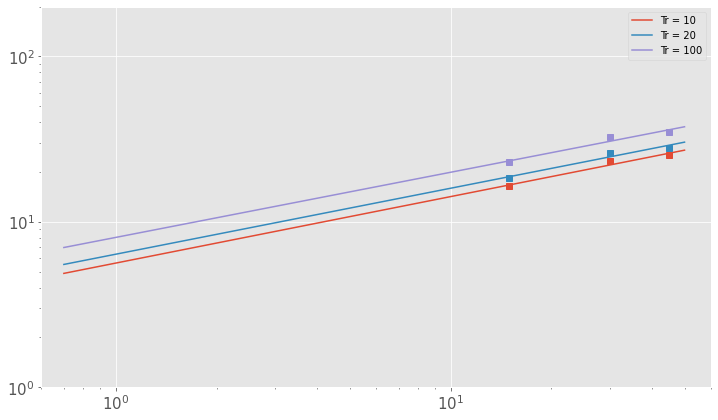

In [57]:
ag=inh.plot()
ag.set_yscale('log')
ag.set_xscale('log')
ag=plot(pts[10],"s",color="#E24A33")
ag=plot(pts[20],"s",color="#348ABD")
ag=plot(pts[100],"s",color="#988ED5")
plt.xlim([0.6,60])
plt.ylim([1,200])

## Commenti
Come si può notare dai grafici, queste curve sono ben interpolate.